# GDELT API CookBook

The **[GDELT](https://www.gdeltproject.org/) (Global Database of Events, Language and Tone)** is the largest, most comprehensive, and highest resolution open database of human society ever created. It **tracks all media publications published worldwide in 65 languages every 15 minutes**.

With this simple code, you can:

*  **`timelinevolraw` mode**: Extract the volume (count) of matched publications.
*  **`timelinetone` mode**: Extract the tone (average sentiment) of the matched publications.
*  **`artlist` mode**: See the specific URLs of the matched publications (a max of 25 URLs are displayed). This can be used for validation.

In this notebook, we will fo the following to construct any sentiment index:

1.  **Extract the data** associated with the issue to be analyzed (volume and tone).
2.  **Extract the total volume** of publications during the studied period (in any topic).
3.  **Construct a sentiment index** following the formula: `Index = Volume/Total_Volume * Tone`.
4.  **Process the index**: smooth (by applying a moving average), remove seasonalities (by expressing values in growths rather than levels) and standardize (to see deviations from normal behavior).
5.  **Visualize** the resulting index.
6.  **Validate** the index by examining specific periods of amplified sentiment.

In [ ]:
!pip install gdeltdoc
from gdeltdoc import GdeltDoc, Filters

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from time import sleep
import re

GDELT API is called by using a query string that looks like this (e.g.): `immigration spain theme:(theme:MIGRATION OR theme:IMMIGRATION) sourcecountry:SP&startdatetime=20240101000000&enddatetime=20241231235959&timezoom=yes`. As such, the following code will help construct the proper query and use it to extract the volume, tone and sample URLs of the articles that match the specified search.

In [ ]:
country_codes = {
 'United Arab Emirates': 'AE',
 'Afghanistan': 'AF',
 'Albania': 'AL',
 'Algeria': 'AG',
 'Azerbaijan': 'AJ',
 'Armenia': 'AM',
 'Angola': 'AO',
 'Argentina': 'AR',
 'Australia': 'AS',
 'Austria': 'AU',
 'Bahrain': 'BA',
 'Botswana': 'BC',
 'Belgium': 'BE',
 'Bangladesh': 'BG',
 'Belize': 'BH',
 'Bolivia': 'BL',
 'Bosnia': 'BK',
 'Burma': 'BM',
 'Benin': 'BN',
 'Belarus': 'BO',
 'Brazil': 'BR',
 'Bhutan': 'BT',
 'Bulgaria': 'BU',
 'Brunei': 'BX',
 'Burundi': 'BY',
 'Canada': 'CA',
 'Cambodia': 'CB',
 'Chad': 'CD',
 'Sri Lanka': 'CE',
 'China': 'CH',
 'Chile': 'CI',
 'Cameroon': 'CM',
 'Congo': 'CF',
 'Colombia': 'CO',
 'Costa Rica': 'CS',
 'Central African Republic': 'CT',
 'Cuba': 'CU',
 'Cyprus': 'CY',
 'Denmark': 'DA',
 'Djibouti': 'DJ',
 'Dominican Republic': 'DR',
 'Ecuador': 'EC',
 'Egypt': 'EG',
 'Ireland': 'EI',
 'Estonia': 'EN',
 'Eritrea': 'ER',
 'Ethiopia': 'ET',
 'Czech Republic': 'EZ',
 'Finland': 'FI',
 'Fiji': 'FJ',
 'France': 'FR',
 'Gabon': 'GB',
 'Gambia': 'GA',
 'Georgia': 'GG',
 'Ghana': 'GH',
 'Germany': 'GM',
 'Guam': 'GQ',
 'Greece': 'GR',
 'Guatemala': 'GT',
 'Guinea': 'GV',
 'Guyana': 'GY',
 'Haiti': 'HA',
 'Hong Kong': 'HK',
 'Honduras': 'HO',
 'Croatia': 'HR',
 'Hungary': 'HU',
 'Iceland': 'IC',
 'Indonesia': 'ID',
 'India': 'IN',
 'Iran': 'IR',
 'Israel': 'IS',
 'Ivory Coast': 'IV',
 'Italy': 'IT',
 'Iraq': 'IZ',
 'Japan': 'JA',
 'Jersey': 'JE',
 'Jamaica': 'JM',
 'Jordan': 'JO',
 'Kenya': 'KE',
 'Kyrgyzstan': 'KG',
 'North Korea': 'KN',
 'South Korea': 'KS',
 'Kuwait': 'KU',
 'Kosovo': 'KV',
 'Kazakhstan': 'KZ',
 'Laos': 'LA',
 'Lebanon': 'LE',
 'Latvia': 'LG',
 'Lithuania': 'LH',
 'Liberia': 'LI',
 'Luxembourg': 'LU',
 'Libya': 'LY',
 'Madagascar': 'MA',
 'Macau': 'MC',
 'Moldova': 'MD',
 'Mayotte': 'MF',
 'Mongolia': 'MG',
 'Malawi': 'MI',
 'Macedonia': 'MK',
 'Mali': 'ML',
 'Monaco': 'MN',
 'Morocco': 'MO',
 'Mauritius': 'MP',
 'Mauritania': 'MR',
 'Malta': 'MT',
 'Oman': 'MU',
 'Maldives': 'MV',
 'Mexico': 'MX',
 'Malaysia': 'MY',
 'Mozambique': 'MZ',
 'Niger': 'NG',
 'Nigeria': 'NI',
 'Netherlands': 'NL',
 'Norway': 'NO',
 'Nepal': 'NP',
 'Suriname': 'NS',
 'Nicaragua': 'NU',
 'New Zealand': 'NZ',
 'South Sudan': 'OD',
 'Paraguay': 'PA',
 'Peru': 'PE',
 'Pakistan': 'PK',
 'Poland': 'PL',
 'Panama': 'PM',
 'Portugal': 'PO',
 'Papua New Guinea': 'PP',
 'Qatar': 'QA',
 'Serbia': 'RI',
 'Romania': 'RO',
 'Philippines': 'RP',
 'Puerto Rico': 'RQ',
 'Russia': 'RS',
 'Rwanda': 'RW',
 'Saudi Arabia': 'SA',
 'Seychelles': 'SE',
 'South Africa': 'SF',
 'Senegal': 'SG',
 'Slovenia': 'SI',
 'Sierra Leone': 'SL',
 'Singapore': 'SN',
 'Somalia': 'SO',
 'Spain': 'SP',
 'Sudan': 'SU',
 'Sweden': 'SW',
 'Syria': 'SY',
 'Switzerland': 'SZ',
 'Thailand': 'TH',
 'Tajikistan': 'TI',
 'Togo': 'TO',
 'Tunisia': 'TS',
 'Turkey': 'TU',
 'Taiwan': 'TW',
 'Turkmenistan': 'TX',
 'Tanzania': 'TZ',
 'Uganda': 'UG',
 'Ukraine': 'UP',
 'Burkina Faso': 'UV',
 'Uruguay': 'UY',
 'Uzbekistan': 'UZ',
 'Venezuela': 'VE',
 'Vietnam': 'VM',
 'Namibia': 'WA',
 'Yemen': 'YM',
 'Zambia': 'ZA',
 'Zimbabwe': 'ZI',
 'United Kingdom': 'UK',
 'United States': 'US'
}

In [40]:
# Initiate GDELT
gd = GdeltDoc()

# Parameters
START_DATE = "20171201"  #YYYYmmdd format
END_DATE = "20241231"   #YYYYmmdd format
COUNTRY = "CO"  # FIPS code of the publications source country (check https://en.wikipedia.org/wiki/List_of_FIPS_country_code)
THEME = "ECON_DEBT"  # Check potential themes at http://data.gdeltproject.org/api/v2/guides/LOOKUP-GKGTHEMES.TXT.
KEYWORDS = "Colombia"  # Must follow format: KEYWORD1 and (KEYWORD2 OR KEYWORD3)

urls = [] # For storing the URLs of the first 25 matched

# API Query Construction
query_string = (
    f"{KEYWORDS} theme:{THEME} sourcecountry:{COUNTRY}"
    f"&startdatetime={START_DATE}000000"
    f"&enddatetime={END_DATE}235959&timezoom=yes"
)

# API Call
try:
  # URL list (for validation)
  articles_data = gd._query("artlist", query_string)
  if articles_data and "articles" in articles_data:
    articles = list(pd.DataFrame(articles_data['articles'])['url'])
    urls.extend(articles)

  # Article Volume & Tone
  volume = gd._query("timelinevolraw", query_string)
  if volume:
    total_volume = sum(entry['value'] for entry in volume['timeline'][0]['data'])
    volumes = volume['timeline'][0]['data']
    volumes = pd.DataFrame(volumes)
    volumes['Date'] = pd.to_datetime(volumes['date'].str[:8], format='%Y%m%d')
    volumes = volumes.groupby('Date')['value'].sum().rename('Volume')

  tone = gd._query("timelinetone", query_string)
  if tone:
    tones = tone['timeline'][0]['data']
    tones = pd.DataFrame(tones)
    tones['Date'] = pd.to_datetime(tones['date'].str[:8], format='%Y%m%d')
    tones = tones.groupby('Date')['value'].mean().rename('Tone')

  results = pd.concat([volumes, tones], axis=1)

except Exception as e:
  print(f"Error querying GDELT: {e}")

print(results)
print(f"Total articles extracted from {START_DATE} to {END_DATE}:" , total_volume)
print('Sample articles extracted below:')
urls

            Volume    Tone
Date                      
2017-12-03       7 -0.9394
2017-12-04      21 -1.9788
2017-12-05      14 -2.2612
2017-12-06      11  0.3600
2017-12-07      17 -0.9579
...            ...     ...
2024-12-27       6 -1.9412
2024-12-28       3 -2.1219
2024-12-29       5 -2.1491
2024-12-30       7 -2.9377
2024-12-31       7 -3.8224

[2584 rows x 2 columns]
Total articles extracted from 20171201 to 20241231: 25247
Sample articles extracted below:


['https://www.pulzo.com/economia/que-tipo-deuda-colombia-prescribe-3-anos-cual-5-anos-PP3986945A',
 'https://hoydiariodelmagdalena.com.co/archivos/1041739/deuda-externa-de-colombia-alcanza-usd-197-361-millones-en-septiembre/',
 'https://www.portafolio.co/economia/gobierno/alemania-haria-canje-de-deuda-por-accion-climatica-con-colombia-616373',
 'https://www.eltiempo.com/vida/viajar/cuales-son-los-destinos-mas-economicos-para-que-los-viajeros-colombianos-aprovechen-el-cambio-de-moneda-3388476',
 'https://www.banrep.gov.co:443/es/publicaciones-investigaciones/boletin-cuentas-financieras/tercer-trimestre-2024',
 'https://www.hsbnoticias.com/inversion-13/',
 'https://www.rcnradio.com/economia/ministro-de-hacienda-se-reune-en-washington-con-el-fmi-para-financiar-credito-de-la-nacion-a-tasas-mas-bajas',
 'https://www.pulzo.com/economia/gustavo-petro-dijo-que-servicio-deuda-colombia-se-pagara-PP4168595A',
 'https://caracol.com.co/2024/10/21/precio-del-dolar-hoy-21-de-octubre-en-colombia-asi-c

We also need to **extract the total number of publications for the day** in the country studied, so that there cannot be any biases related to the general media publishing more or less than usual for reasons not related to the issue being examined.

In [41]:
# API Query Construction
query_string = (
    f"sourcecountry:{COUNTRY}"
    f"&startdatetime={START_DATE}000000"
    f"&enddatetime={END_DATE}235959&timezoom=yes"
)

# API Call
try:
  # Article Volume only
  volume = gd._query("timelinevolraw", query_string)
  if volume:
    total_volume = sum(entry['value'] for entry in volume['timeline'][0]['data'])
    volumes = volume['timeline'][0]['data']
    volumes = pd.DataFrame(volumes)
    volumes['Date'] = pd.to_datetime(volumes['date'].str[:8], format='%Y%m%d')
    volumes = volumes.groupby('Date')['value'].sum().rename('Volume')
except Exception as e:
  print(f"Error querying GDELT: {e}")

print(volumes)
results['Total Volume'] = volumes
print(f"Total articles extracted from {START_DATE} to {END_DATE}:" , total_volume)
print('Sample articles extracted below:')

Date
2017-12-03    2027
2017-12-04    3024
2017-12-05    3781
2017-12-06    3745
2017-12-07    3726
              ... 
2024-12-27    1019
2024-12-28     481
2024-12-29     408
2024-12-30     536
2024-12-31    1064
Name: Volume, Length: 2584, dtype: int64
Total articles extracted from 20171201 to 20241231: 3650609
Sample articles extracted below:


A **simple index** that incorporates both media volume and tone can be constructed to **better visualize society behavior**.

<Axes: title={'center': 'Society Behavior'}, xlabel='Date', ylabel='Standard Deviations'>

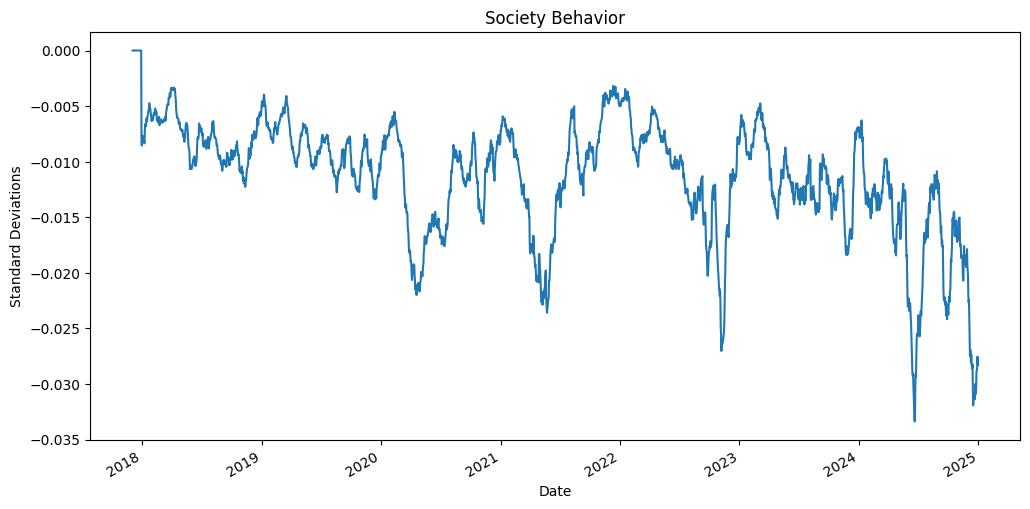

In [42]:
results['Index'] = results['Volume']/results['Total Volume'] * results['Tone']
results['Index'] = results['Index'].rolling(window=28).mean().fillna(0) # OPTIONAL: Apply a 28-day moving average to remove weekly seasonality
#results['Index'] = results['Index'].pct_change(periods=365) # OPTIONAL: Express in yearly growth (YoY) to remove yearly seasonality
results['Index'].plot(figsize=(12, 6), title='Society Behavior', ylabel='Standard Deviations')

For better visualization of the results, since `volume` (number of articles matching the query) is a count (positive integers) and `tone` (average sentiment of the matched articles) is in the [-5, 5] range approximately, **data standarization** can be performed. This way, normal values stay around 0, while deviations indicate a more extreme behavior.

<ipython-input-43-93d90c50714d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results[col] = (results[col] - results[col].mean()) / results[col].std()


<Axes: title={'center': 'Volume and Tone Evolution of the Media'}, xlabel='Date', ylabel='Standard Deviations'>

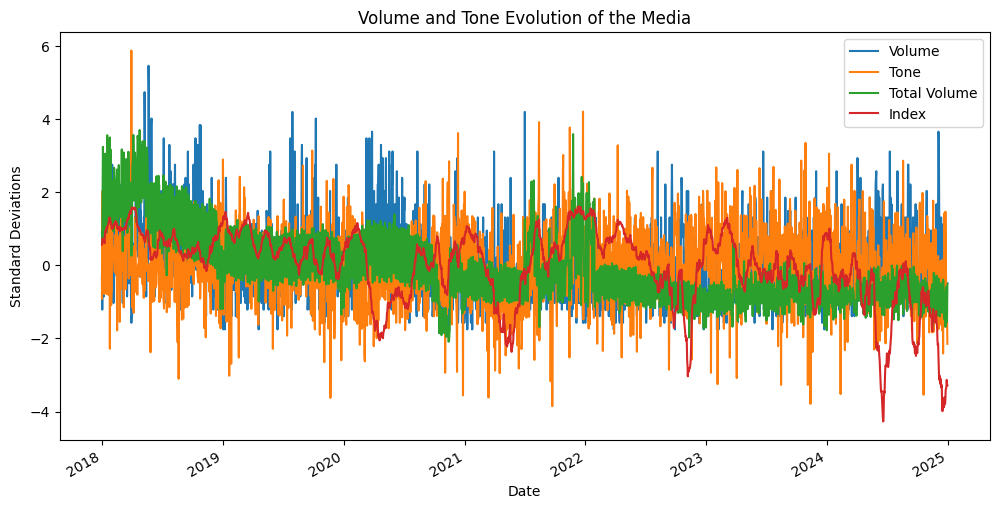

In [43]:
# Standardization
results = results.iloc[28:]  # Remove first 28 days (empty after smoothing) to prevent affecting the standardization
for col in results.columns:
  results[col] = (results[col] - results[col].mean()) / results[col].std()

results.plot(figsize=(12, 6), title='Volume and Tone Evolution of the Media', ylabel='Standard Deviations')

## *How can we validate the constructed indicator accurately reflects society behavior?*

We can **validate the indicator's performance against relevant historical events**.

In [44]:
def plot(dataframe, columns, event_date, start_date=None, end_date=None):
    highlight_date_parsed = pd.to_datetime(event_date, format="%d-%m-%Y")

    # Set default start_date and end_date if not provided
    if not start_date and highlight_date_parsed:
        start_date = (highlight_date_parsed - pd.Timedelta(days=60)).strftime("%d-%m-%Y")
    if not end_date and highlight_date_parsed:
        end_date = (highlight_date_parsed + pd.Timedelta(days=60)).strftime("%d-%m-%Y")

    # Convert start_date and end_date to datetime objects
    start_date_parsed = pd.to_datetime(start_date, format="%d-%m-%Y")
    end_date_parsed = pd.to_datetime(end_date, format="%d-%m-%Y")

    # Filter the data within the date range
    filtered_data = dataframe[(dataframe.index >= start_date_parsed) &
                              (dataframe.index <= end_date_parsed)][columns]

    plt.figure(figsize=(10, 6))

    # Plot each column
    for col in columns:
        plt.plot(filtered_data.index, filtered_data[col], linestyle='-', label=col)

        # Highlight the value of the specific day if provided
        if highlight_date_parsed and highlight_date_parsed in filtered_data.index:
            plt.scatter(highlight_date_parsed, filtered_data.loc[highlight_date_parsed, col],
                        color='yellow', edgecolor='black', zorder=5, s=100)

    # Configure plot appearance
    plt.xlabel('Date', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))  # Format as 'YYYY-MM'
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.title(f'Immigration', fontsize=14)
    plt.axhline(0, color='black')
    plt.axhline(-1, color='grey', linestyle='--')
    plt.axhline(1, color='grey', linestyle='--')
    plt.legend(fontsize=10)
    plt.show()

**Validation Example**: check whether the media properly covered the historical event at hand.

*On September 11-15, 2024, approximately 4,000 Moroccans, including nearly 150 minors, attempted to illegally enter Ceuta (Spain). This period saw a notable increase in organized, mass attempts to breach the border, with social media playing a significant role in coordinating these efforts.*

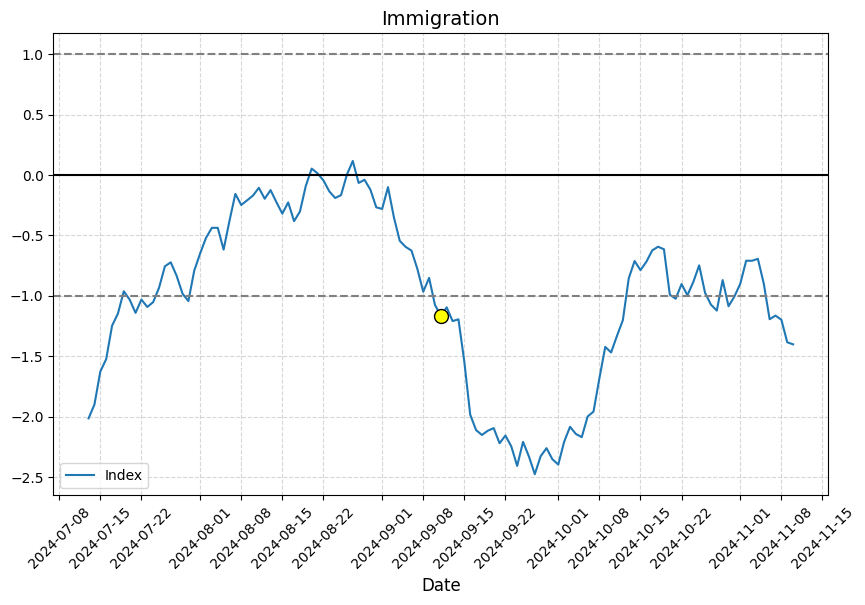

In [45]:
plot(results, ['Index'], '11-09-2024')